In [1]:
# This script generates dataset with labels
import json
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def get_data(data):
    '''
    get the timestamp and 3-component acceleration data. 
    '''
    # read in x, y, z data
    x = np.array(data['data']['x'])
    y = np.array(data['data']['y'])
    z = np.array(data['data']['z'])

    # calculate the timestamp
    # get the start time
    t0 = data['header']['starttime']
    npoints = len(x)
    sampling_rate = data['header']['sampling_rate']
    
    # get the end time 
    t1 = t0 + npoints / sampling_rate
    
    # form the timestamp
    t = np.linspace(t0, t1, npoints)
    
    #trigger time
    try:
        triggerTime = data['header']['triggertime']
        startTime   = data['header']['starttime']
        duration = int((triggerTime - startTime) * sampling_rate)
    except:
        duration = 0
    
    # station latitude and long
    return t, x, y, z, duration

In [3]:
def plot_data(t, x, y, z):
    '''
    helper function to plot the 3-component acceleration data
    '''
    plt.figure()
    plt.subplot(311)
    plt.plot(t, x)
    plt.subplot(312)
    plt.plot(t, y)
    plt.ylabel('Acceleration (g)')
    plt.subplot(313)
    plt.plot(t, z)
    plt.xlabel('Time (sec)')
    plt.show()
    # spectrogram
    plt.figure()
    rate = 25
    timeWindow = 2
    plt.subplot(311)
    specgram(x, NFFT=rate * timeWindow, Fs=rate, noverlap = 5);
    plt.subplot(312)
    specgram(y, NFFT=rate * timeWindow, Fs=rate, noverlap = 5);
    plt.subplot(313)
    specgram(z, NFFT=rate * timeWindow, Fs=rate, noverlap = 5);
    plt.show()

In [4]:
def NaiveTrigger(x, y, z):
    '''
    Naive trigger
    '''
    std_x = np.std(x[0:100])
    std_y = np.std(y[0:100])
    std_z = np.std(z[0:100])
    mean_x = np.mean(x[0:100])
    mean_y = np.mean(y[0:100])
    mean_z = np.mean(z[0:100])
    thres = 6
    for i in range(len(x)):
        if abs(x[i] - mean_x) > 6 * std_x:
            return(i)
        if abs(y[i] - mean_y) > 6 * std_y:
            return(i)
        if abs(z[i] - mean_z) > 6 * std_z:
            return(i)
    raise Exception('Should not be here')

In [5]:
def normalize(x):
    if np.std(x) > 1e-10:
        return((x - median(x))/np.std(x))
    else:
        return(x - median(x))

1
../../data/EQ/shake_table/trial67_phone4.json
10.570977131


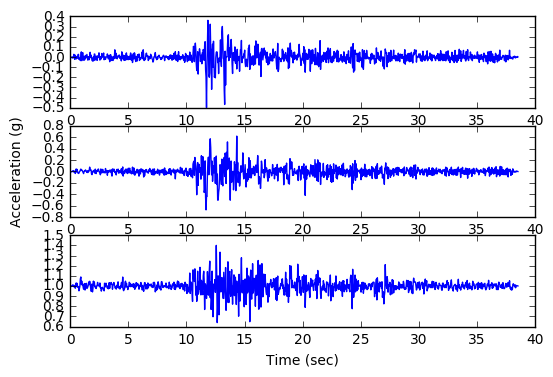

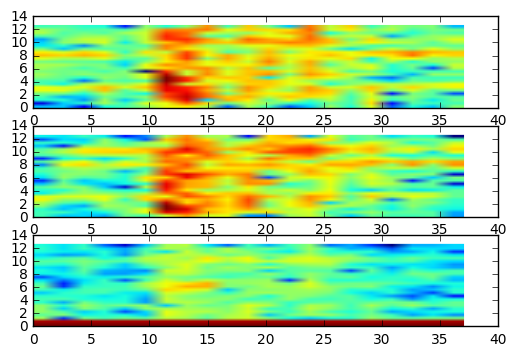

In [6]:
import os
import random
def Sampling(label = None, order = None):
    '''
    Draw a sample from data
    
    Args:
    label: integer, the label of the sample, 1 if shaketable, 0 if human, 2 if simulated
    order: integer, if not None, will give the the file of that order instead of randomly selecting.
    
    Returns:
    t     : 1d array, time.
    x     : 1d array, x.
    y     : 1d array, y orthogonal to x.
    z     : 1d array, z (vertical).
    label : boolean.
    '''
    rng = random.Random()
    if label is None:
        label = (rng.random() > 0.5) * 1
    elif label is True:
        label = 1
    elif label is False:
        label = 0
    if label == 1:
        path = '../../data/EQ/shake_table/'
    elif label == 0:
        path = '../../data/Human/'
    elif label == 2:
        path = '../../data/EQ/simulated/'
    files = os.listdir(path)
    if order is None:
        oneFile = path + rng.sample(files, 1)[0]
    else:
        assert(order < len(files))
        oneFile = path + files[order]
    data = json.load(open(oneFile, 'r'))
    t, x, y, z, duration = get_data(data)
    if label:
        duration = NaiveTrigger(x, y, z)
        
    return(t, x, y, z, label, oneFile, duration)
t, x, y, z, label, filename, duration = Sampling(True, 190)
print(label)
print(filename)
print(t[duration])
#tmp = range(duration - 50, duration + 50)
tmp = range(len(x))
plot_data(t[tmp], x[tmp], y[tmp], z[tmp])
#out = obspy.signal.trigger.classic_sta_lta_py(z, 150, 12)
#plt.plot(out)

In [7]:
# Generate an aggregate dataset with only the data around trigger time
def Aggregate(m = 1000, n = 10000, window = 25, move = [-4, -3, -2, -1, 0, 1, 2, 3, 4]):
    '''
    Aggregate the data between triggerTime+/- window
    Args:
    
    move : move the window to left and still keep the same label
    '''
    data = np.zeros((len(move) * m + n, window * 2 * 3 + 1))
    line = 0
    for trial in range(m):
        t, x, y, z, label, filename, duration = Sampling(1, trial)
        for step in (np.array(move) + duration):
            if step > window and step + window < len(t):
                tmp = range(step - window, step + window)
                data[line, :] = numpy.concatenate((normalize(x[tmp]), normalize(y[tmp]), normalize(z[tmp]), [1]))
                line += 1
            else:
                print('Import Exception 1.')
    for trial in range(m, m + n):
        t, x, y, z, label, filename, duration = Sampling(0, trial - m)
        if duration > window and duration + window < len(t):
            tmp = range(duration - window, duration + window)
            data[line, :] = numpy.concatenate((normalize(x[tmp]), normalize(y[tmp]), normalize(z[tmp]), [0]))
            line += 1
        else:
            tmp = range(0, 2 * window)
            data[line, :] = numpy.concatenate((normalize(x[tmp]), normalize(y[tmp]), normalize(z[tmp]), [0]))
            line += 1
    return(data)
data1 = Aggregate(m = 192, n = 0)
data0 = Aggregate(m = 0, n = 26343)
#data = data1[:2000,:]
#testdata = data1
#testdata = Aggregate()
#print(testdata[1:10,:])
#print(len(np.where(abs(testdata[:,10]) < 1e-4)[0]))

In [8]:
import pickle
f1 = open('data1.pckl', 'wb')
f0 = open('data0.pckl', 'wb')
pickle.dump(data1, f1)
pickle.dump(data0, f0)
f1.close()
f0.close()


In [ ]:
f1 = open('data1.pckl', 'rb')
f0 = open('data0.pckl', 'rb')
data1 = pickle.load(f1)
data0 = pickle.load(f0)
f1.close()
f0.close()